In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import time

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

**Design a query to retrieve the last 12 months of precipitation data and plot the results**

In [19]:
# Calculate the date 1 year ago from the last data point in the database
# Last data point
last_date_query = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_str = last_date_data[0]
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d').date()

# 1 year ago from the last data point
yr_ago_date = last_date - dt.timedelta(days=365)
yr_ago_date_str = yr_ago_date.strftime('%Y-%m-%d')

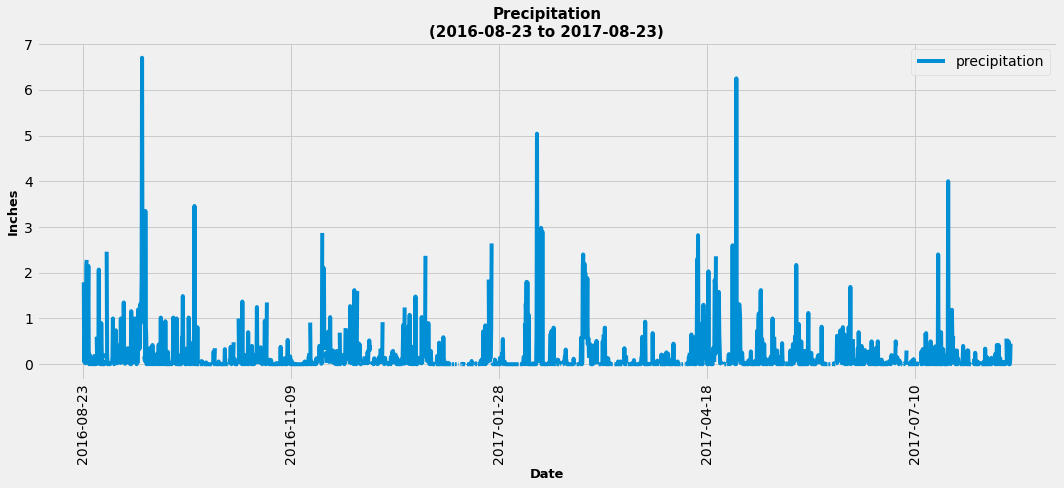

In [94]:
# Perform a query to retrieve the data and precipitation scores
prcp_12m = session.query(Measurement.date, Measurement.prcp)\
                    .filter(Measurement.date <= last_date_str)\
                    .filter(Measurement.date >= yr_ago_date_str).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_12m_df = pd.DataFrame(prcp_12m, columns=['date', 'precipitation']).set_index('date')

# Sort the dataframe by date
prcp_12m_df_sorted =  prcp_12m_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
pd_bar_prcp_12m = prcp_12m_df_sorted.plot(kind='line', rot=90, figsize=(15,7), grid=True)

# Set x/y label, title
plt.title(f'Precipitation\n({yr_ago_date_str} to {last_date_str})', fontweight = 'bold', size=15)
plt.xlabel('Date', fontweight = 'bold', size=13)
plt.ylabel('Inches', fontweight = 'bold', size=13)
plt.tight_layout()

# Save bar graph to Images folder
pd_bar_prcp_12m.figure.savefig('Images/pd_bar_prcp_12m.png')

# Present the bar chart
plt.show()

# To close pyplot
plt.close()

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_st_summary = prcp_12m_df.describe()
prcp_st_summary

,precipitation
count,2011.000000
mean,0.176549
std,0.460667
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [42]:
# Design a query to show how many stations are available in this dataset?
no_station = session.query(Measurement.station).distinct().count()
print(f'There are {no_station} stations available in this dataset')

There are 9 stations available in this dataset


In [60]:
# What are the most active stations? (i.e. what stations have the most rows)?
most_active = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .first()

print(f'The most active station is station id {most_active[0]}')

# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
active_station_df = pd.DataFrame(active_station, columns=['station_id', 'no. of data'])


active_station_df

The most active station is station id USC00519281


,station_id,no. of data
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [64]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
act_stn_summary = session.query(Measurement.station, func.min(Measurement.tobs), 
                                func.max(Measurement.tobs), func.avg(Measurement.tobs))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())\
                                .filter(Measurement.station == most_active[0])

# Save the query results as a Pandas DataFrame and set the index to the date column
act_stn_summary_df = pd.DataFrame(act_stn_summary, columns=['station_id', 'min temp', 'max temp', 'avg temp'])

act_stn_summary_df

,station_id,min temp,max temp,avg temp
0,USC00519281,54.0,85.0,71.663781


In [82]:
# Choose the station with the highest number of temperature observations.
print(f'The station with the highest number of TOBS is station id {most_active[0]}')

The station with the highest number of TOBS is station id USC00519281


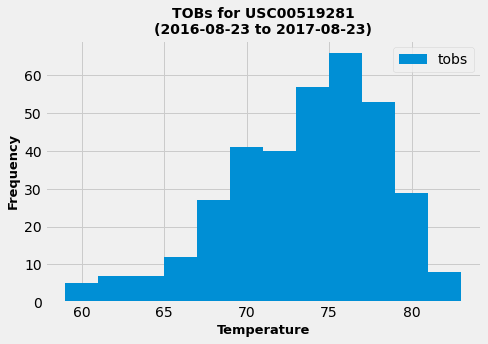

In [120]:
# Query the last 12 months of temperature observation data for this station
st_12m = session.query(Measurement.tobs)\
                    .filter(Measurement.date <= last_date_str)\
                    .filter(Measurement.date >= yr_ago_date_str)\
                    .filter(Measurement.station == most_active[0])\
                    .all()

# Save the query results as a Pandas DataFrame and set the index to the date column
st_12m_df = pd.DataFrame(st_12m, columns=['tobs'])

# Plot the results as a histogram
ax = st_12m_df.plot.hist(bins=12, figsize=(7,5))

# Set x/y label, title
plt.title(f'TOBs for {most_active[0]}\n({yr_ago_date_str} to {last_date_str})', fontweight = 'bold', size=14)
plt.xlabel('Temperature', fontweight = 'bold', size=13)
plt.ylabel('Frequency',fontweight = 'bold', size=13)
plt.tight_layout()

# Save bar graph to Images folder
pd_bar_prcp_12m.figure.savefig('Images/hist_stUSC00519281.png')

# Present the bar chart
plt.show()

# To close pyplot
plt.close()

## Bonus Challenge Assignment

In [121]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
